# Practicing convolutions

In this notebook you will practice applying 2D, 2.5D and 3D convolutions to a medical volume using PyTorch. Conveniently, PyTorch offers the functionality of computing convolutions with arbitrary kernel sizes, and handles all the mechanics of striding and padding

In [2]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from PIL import Image
import math

plt.rcParams["figure.figsize"] = (7,7)

## Applying convolutional filters

In this section we will give you some starter code on how to apply 2D convolution using PyTorch

In [3]:
# Define a 4x4 edge filter kernel

conv_kernel = np.ones((4,4))
conv_kernel[2:,:] = -1
print(conv_kernel)

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]]


In [4]:
# We will use Torch's convolutional layer for our convolutional filter operation

conv2d = nn.Conv2d(
    1, # Input size == 1 (we are dealing with 1 input channel)
    1, # Output size - we want to get 1 channel as an output
    kernel_size = (4, 4), # size of our filter kernel
    bias = False) # We do not need a bias for this operation
conv2d

Conv2d(1, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)

In [5]:
# Let's turn our convolutional kernel into a tensor which we can use to initialize our convolutional layer

params = torch.from_numpy(conv_kernel).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0)

# Note the unsqeeze operation - this is effectively adding empty dimensions to the vector bringing it to 4 dimensions
# Torch expects parameter vector of size (output_channels, input_channels, kernel x dimension, kernel y dimension)

conv2d.weight = torch.nn.Parameter(params)

In [6]:
params.shape

torch.Size([1, 1, 4, 4])

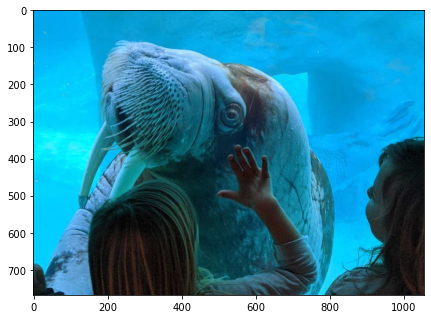

In [7]:
# Let's load an image of the adorable walrus:

walrus = Image.open('data/walrus.jpg')
plt.imshow(walrus)

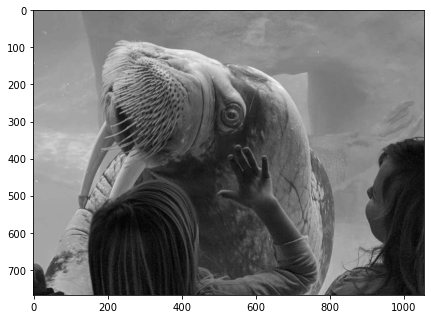

In [8]:
# Now let's convert it to grayscale and normalize (because this is what our convolution operation is expecting)

walrus = walrus.convert("L")
walrus = np.array(walrus)
walrus = walrus.astype(np.single)/0xff

plt.imshow(walrus, cmap="gray")

In [9]:
# Conv2D layer is expecting a 4D tensor (batch_size, channels, width, height)
# Let's bring the walrus into proper shape. We have batch of size one and only one channel
# so we will use the unsqueeze operation for this

walrus_tensor = torch.from_numpy(walrus).unsqueeze(0).unsqueeze(1)
walrus_tensor.shape

torch.Size([1, 1, 768, 1054])

In [10]:
%%time
# Let's compute the convolution map and ReLU activations. Note that we also used the time "magic function"
# to see how long it takes. Later on, you will compare other convolution methods that you will try.

convolved = conv2d(walrus_tensor)
relu = F.relu(convolved)

CPU times: user 44 ms, sys: 9.06 ms, total: 53.1 ms
Wall time: 60.1 ms


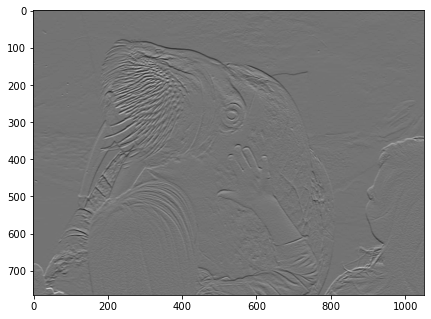

In [11]:
# And let's visualize them!

plt.imshow(np.squeeze(convolved.detach().numpy()), cmap="gray")

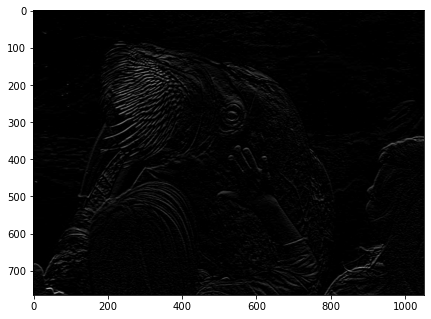

In [12]:
plt.imshow(np.squeeze(relu.detach().numpy()), cmap="gray")

Hurray, we've run a 2D convolutional layer with custom kernel, using PyTorch. Onwards to medical applications!

## Loading a NIFTI volume

Remember how to use NiBabel to load those NIFTI volumes? Here's a refresher

In [13]:
# Let's load our image

nii_img = nib.load("data/spleen.nii.gz")
img = nii_img.get_fdata()

In [14]:
img.shape

(512, 512, 41)

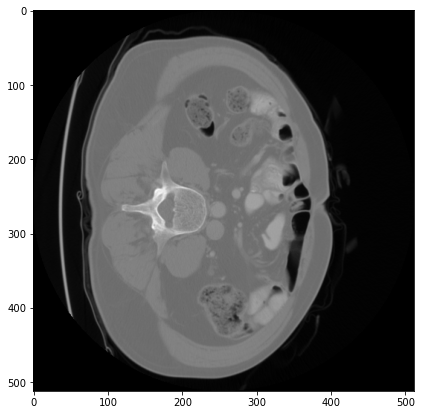

In [15]:
# Let's visualize a slice:

plt.imshow(img[:,:,0], cmap="gray")

By now you should've seen enough of these to recognize that you are looking at an abdominal cross-section. Now you are ready to apply convolutions!

But before we go there - a couple of notes about pixel sizes, on this particular image.

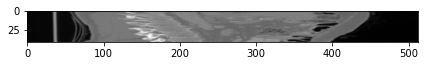

In [16]:
# Let's visualize sagittal cross-section at cut 250 (we will use rot90 since we want to orient the image it properly)

plt.imshow(np.rot90(img[250,:,:]), cmap = "gray")

Wow, that looks squished!

Remember our conversations about anisotropic voxels ? As you might have guessed, our pixels are much shorter in z dimension than they are in x and y. Let's see what we can do about it.

In [17]:
nii_img.header["pixdim"]

array([1.      , 0.744141, 0.744141, 5.      , 0.      , 0.      ,
       0.      , 0.      ], dtype=float32)

Remember how we scaled DICOM image in previous lesson, to account for difference between in-plane resolution and resolution across z-axis? In NIFTI one extracts proper voxel aspect ratio from NIFTI image using the pixdim field.

Unlike DICOM, NIFTI files store all their pixel dimensions in a single place - pixdim field. Also unlike DICOM this field also stores a bunch of other stuff related to uses of NIFTI format beyond static 3D images. If you're curious what those are - check out the [NIFTI documentation](https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/pixdim.html/document_view). 

For the purpose of this exercise we are interested in values at locations 1, 2 and 3 - these are our x, y and z dimensions respectively.

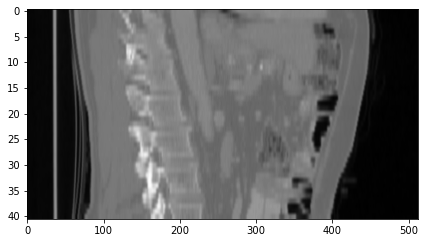

In [18]:
img2d = np.rot90(img[250,:,:])
plt.imshow(img2d, cmap = "gray", aspect=nii_img.header["pixdim"][3]/nii_img.header["pixdim"][1])

In [19]:
# We will also give you a convenience function to visualize all slices in a grid as thumbnails:

def display_volume_slices(img, w, h):
    plot_w = w
    plot_h = h

    # You can play with figsize parameter to adjust how large the images are
    fig, ax = plt.subplots(plot_h, plot_w, figsize=[35,35])

    for i in range(plot_w*plot_h):
        plt_x = i % plot_w
        plt_y = i // plot_w
        if (i < len(img)):
            ax[plt_y, plt_x].set_title(f"slice {i}")
            ax[plt_y, plt_x].imshow(img[i], cmap='gray')
        ax[plt_y, plt_x].axis("off")

    plt.show()

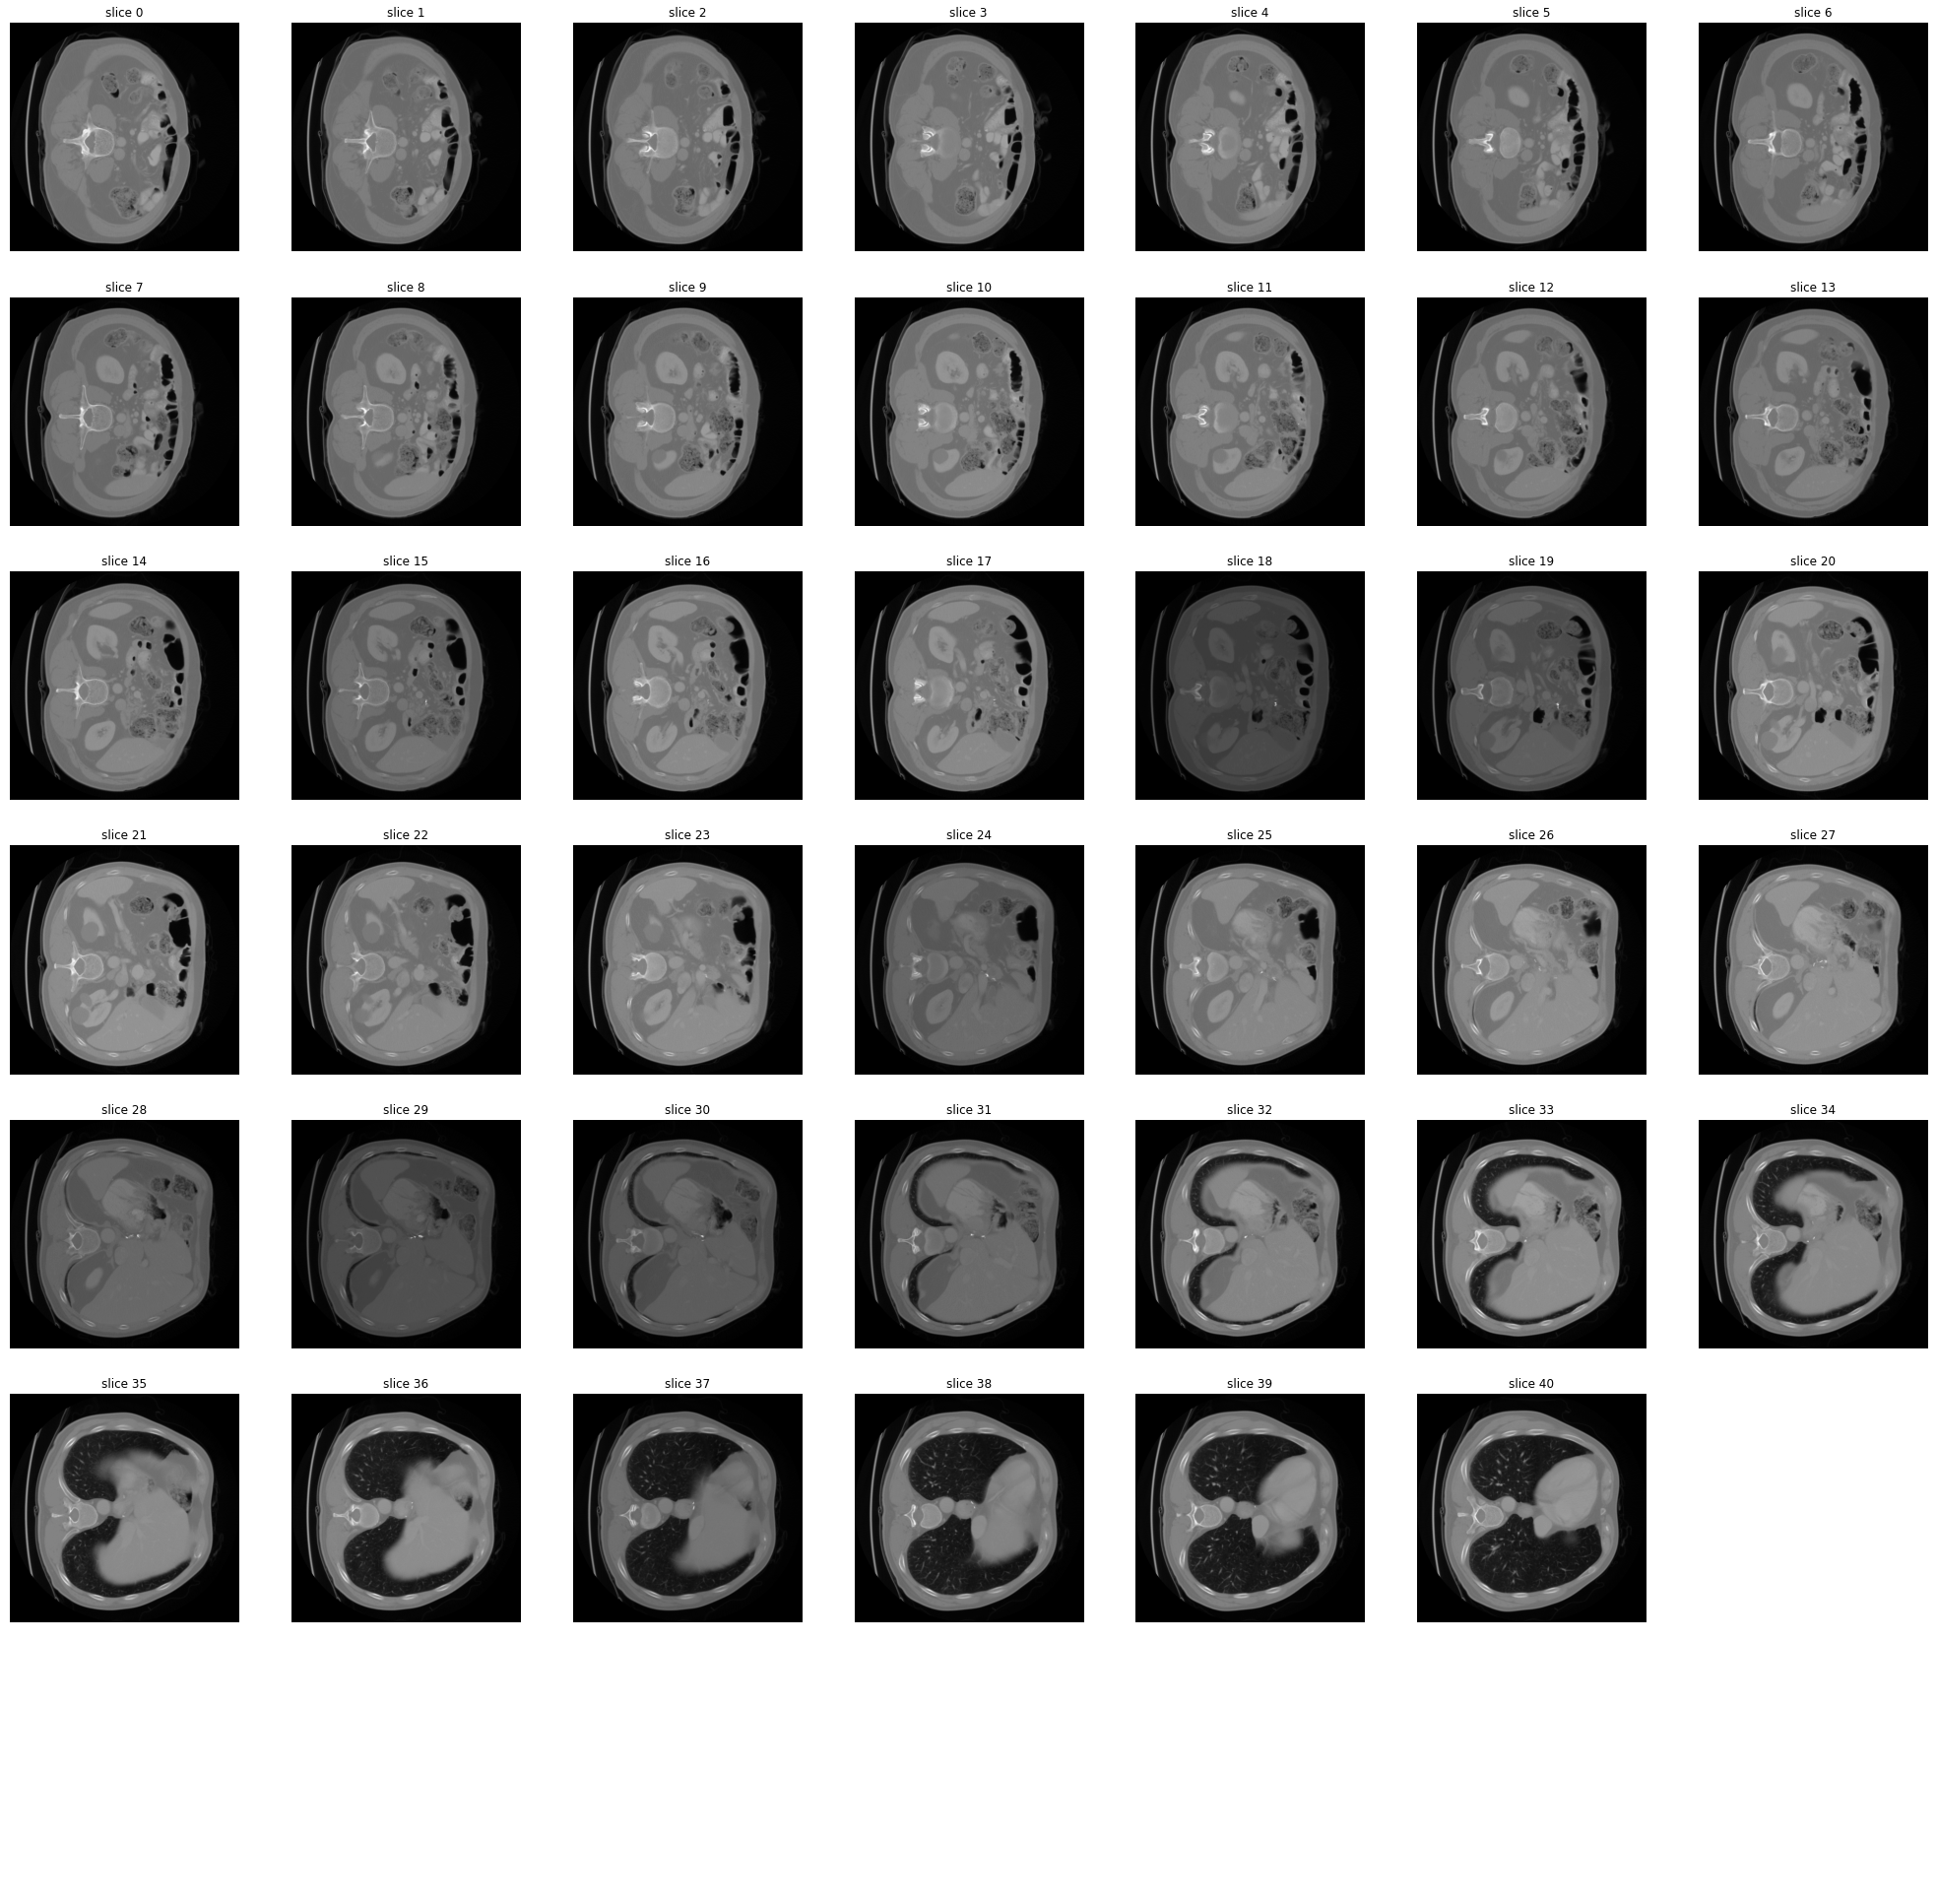

In [20]:
# And let's visualize ALL slices
#
# Note that we are calling np.transpose here because our display_volume_slices iterates over 0th dimension
# of the input volume. Our Nibabel volumes have z dimension stored in the 2nd position, so we 
# move the z-dimension in front of the other two here

display_volume_slices(np.transpose(img, (2, 0, 1)), 7, 7)

---

## 2D Convolutions

**TASK**: Using the kernel we have defined above (or any other kernel you like), use the "2D Convolution" method to create a volume of convolution maps for all of the slices in our volume. Visualize them.

Use %%time (as we've done above) to see how much time it takes.  
How many parameters does define the convolution operation?

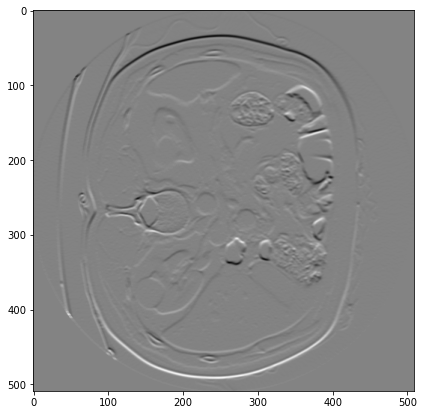

In [21]:
# Let's just reuse the convolutional layer defined above and apply it to every slice to get our volume

conv_slices = []

for ix in range(0, img.shape[2]):
    slice_tensor = torch.from_numpy((img[:,:,ix].astype(np.single)/0xff)).unsqueeze(0).unsqueeze(1)
    convolved = conv2d(slice_tensor)
    conv_slices.append(np.squeeze(convolved.detach().numpy()))

plt.imshow(conv_slices[20], cmap="gray")

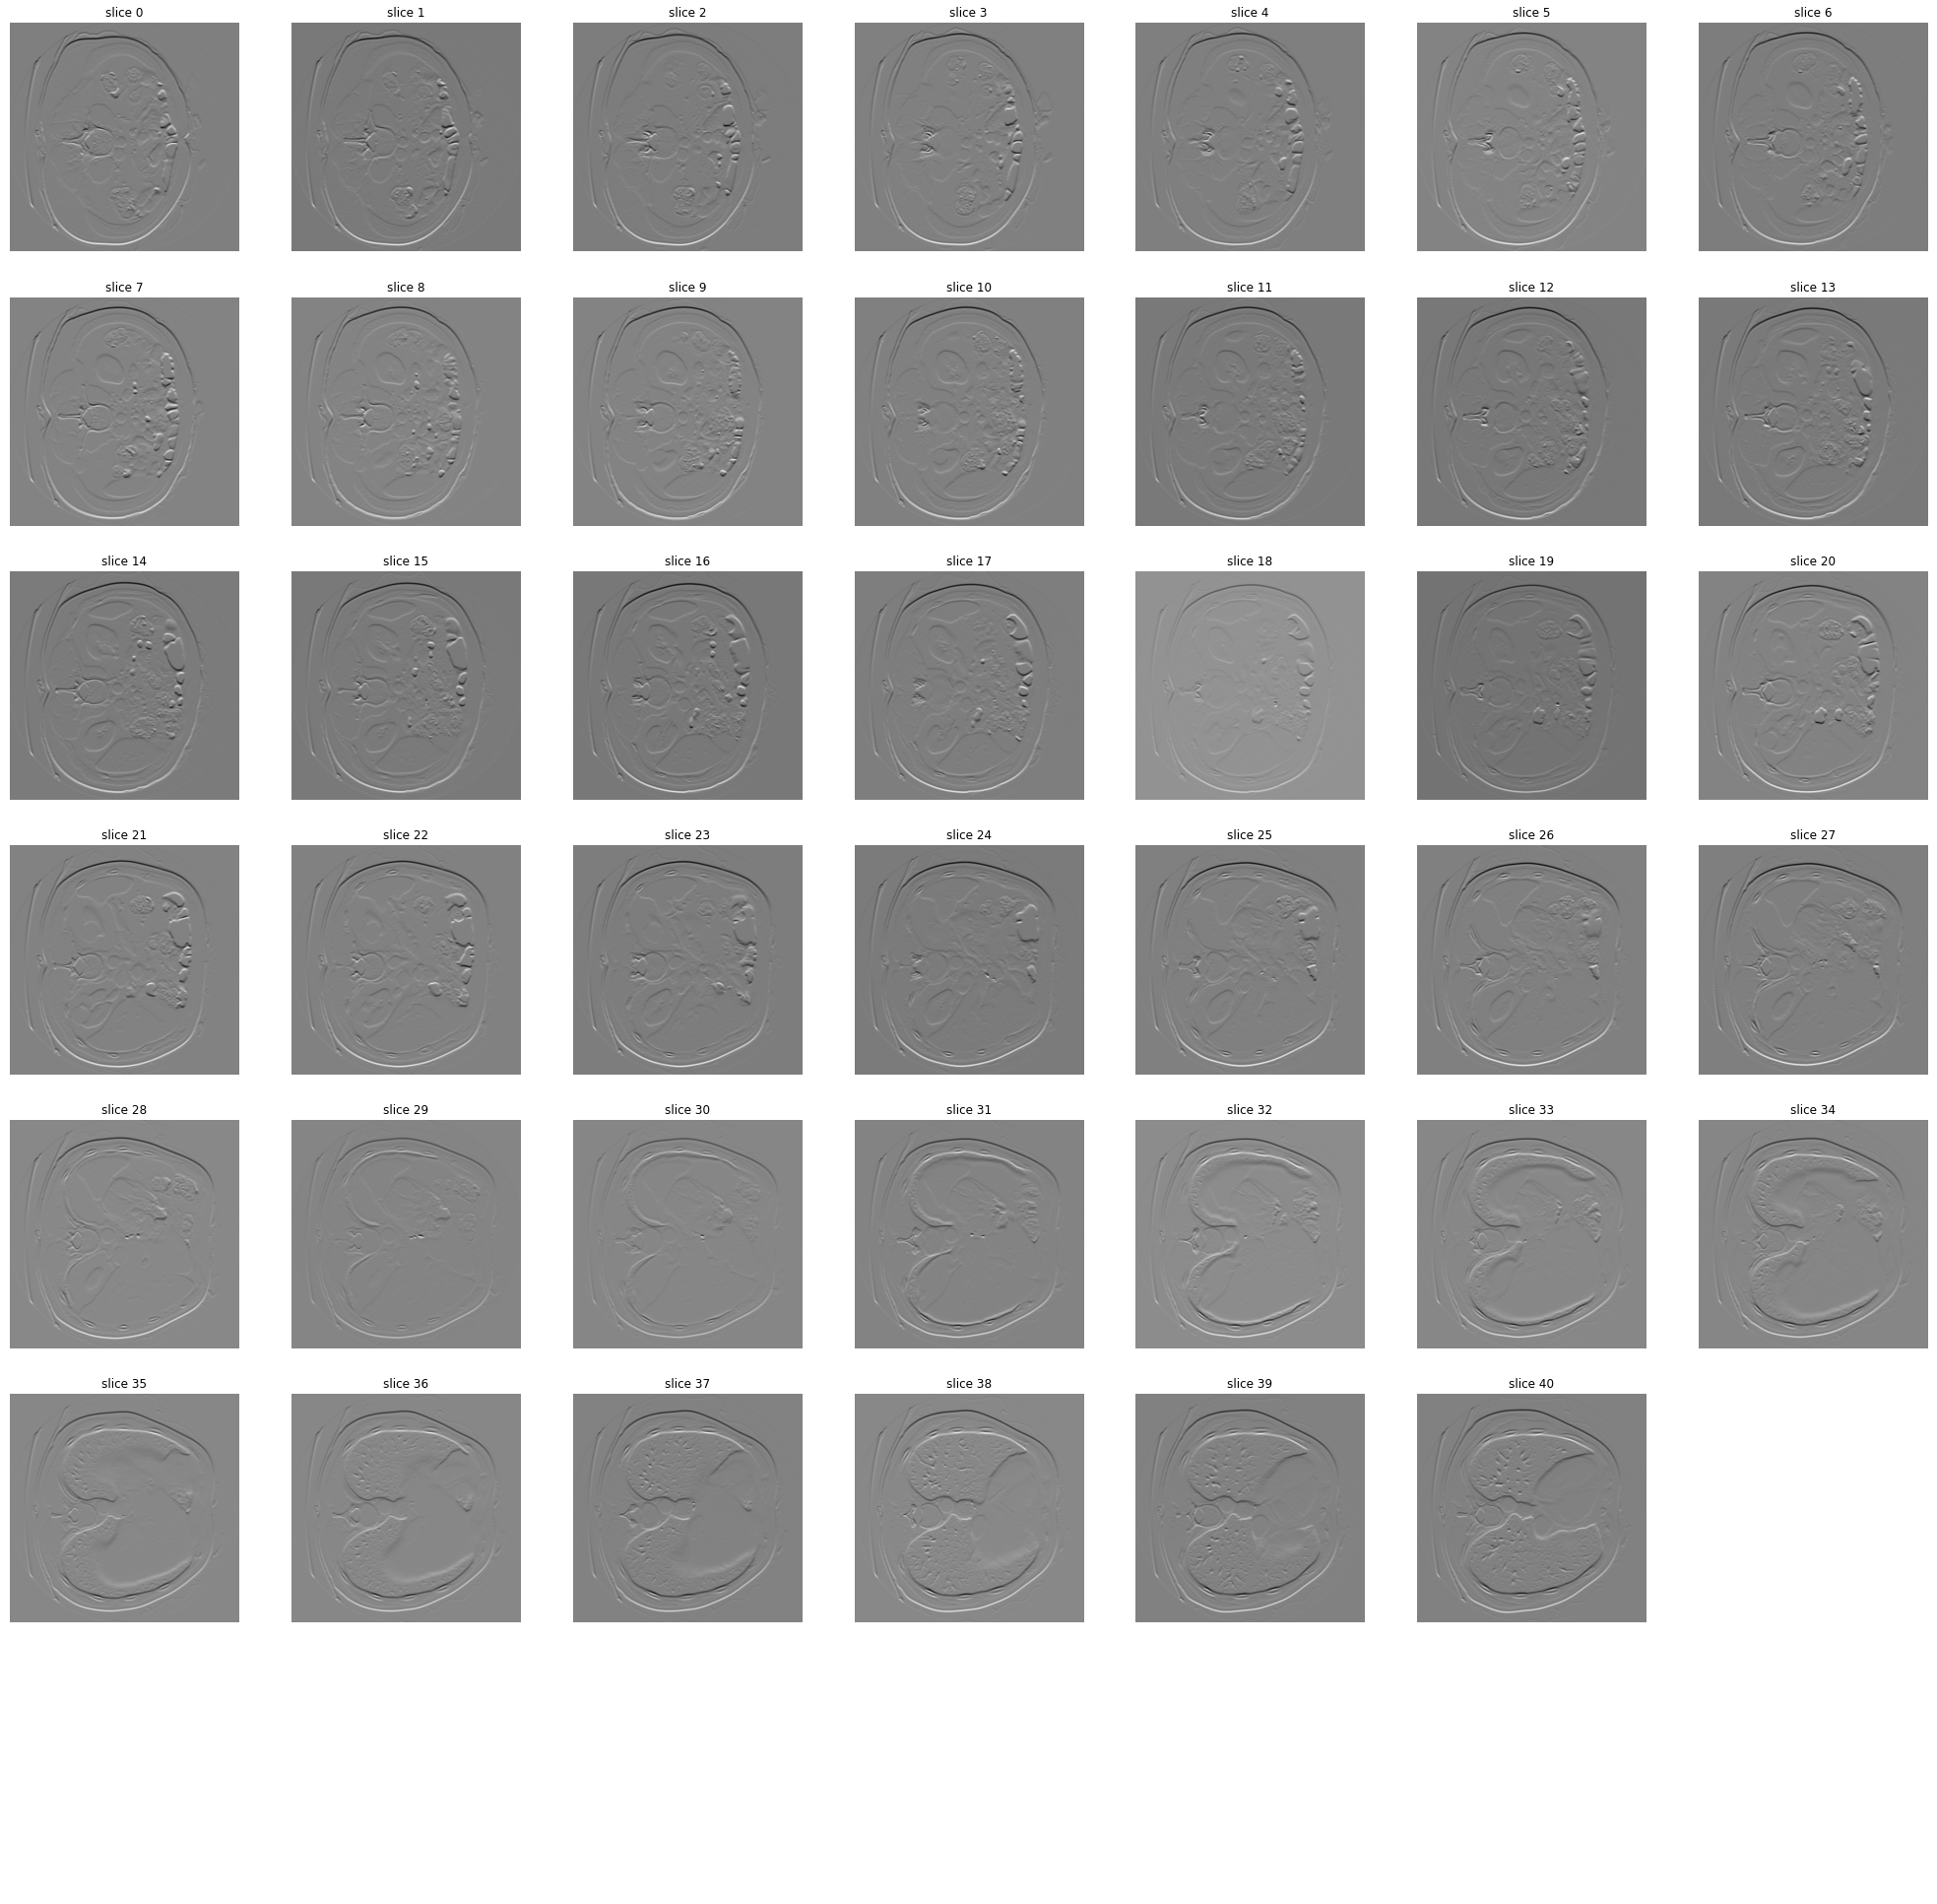

In [22]:
# Let's visualize the slices. See how our filter makes areas of the image where there's a lot going on stand out?

display_volume_slices(conv_slices, 7, 7)

In [23]:
# Let's take a look at our parameter vector - how many knobs does our convolution operation have in total?
# You can guess for this one - that's the size of our conv matrix

conv2d.weight.shape

torch.Size([1, 1, 4, 4])

In [24]:
print(f"Number of trainable parameters: {np.prod(conv2d.weight.shape)}")

Number of trainable parameters: 16


----

# 3D Convolutions

**TASK**: Using a 3D version of the same kernel, compute and time full 3D convolutions by using PyTorch's Conv3D layer. Note that our kernel represents a 2D edge filter. What would be a 3D edge filter?

In [25]:
conv3d = nn.Conv3d(
    1, # Input size == 1 (we are dealing with 1 input channel)
    1, # Output size - we want to get 1 channel as an output
    kernel_size = (4, 4, 4), # size of our kernel filter
    bias = False) # We do not need a bias for this operation
conv3d

Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)

In [26]:
# Build the kernel
conv_kernel3d = np.array([conv_kernel, conv_kernel, -conv_kernel, -conv_kernel])
conv_kernel3d.shape

(4, 4, 4)

In [27]:
# Confirm what form of the weights is expected
conv3d.weight.shape

torch.Size([1, 1, 4, 4, 4])

In [28]:
# Set up weights
params3d = torch.from_numpy(conv_kernel3d).type(torch.FloatTensor).unsqueeze(0).unsqueeze(0) 
conv3d.weight = torch.nn.Parameter(params3d)

In [29]:
# Convert image to tensor that works for our conv3d filter
conv_tensor = torch.from_numpy((img.astype(np.single)/0xff)).unsqueeze(0).unsqueeze(1)
conv_tensor.shape

torch.Size([1, 1, 512, 512, 41])

In [30]:
conv_tensor.dtype

torch.float32

In [31]:
%%time
# Run convolution
convolved = conv3d(conv_tensor)
convolved.shape

CPU times: user 2.35 s, sys: 1.14 s, total: 3.49 s
Wall time: 1.8 s


torch.Size([1, 1, 509, 509, 38])

In [32]:
convolved_np = np.transpose(np.squeeze(convolved.detach().numpy()), (2, 0, 1))
convolved_np.shape

(38, 509, 509)

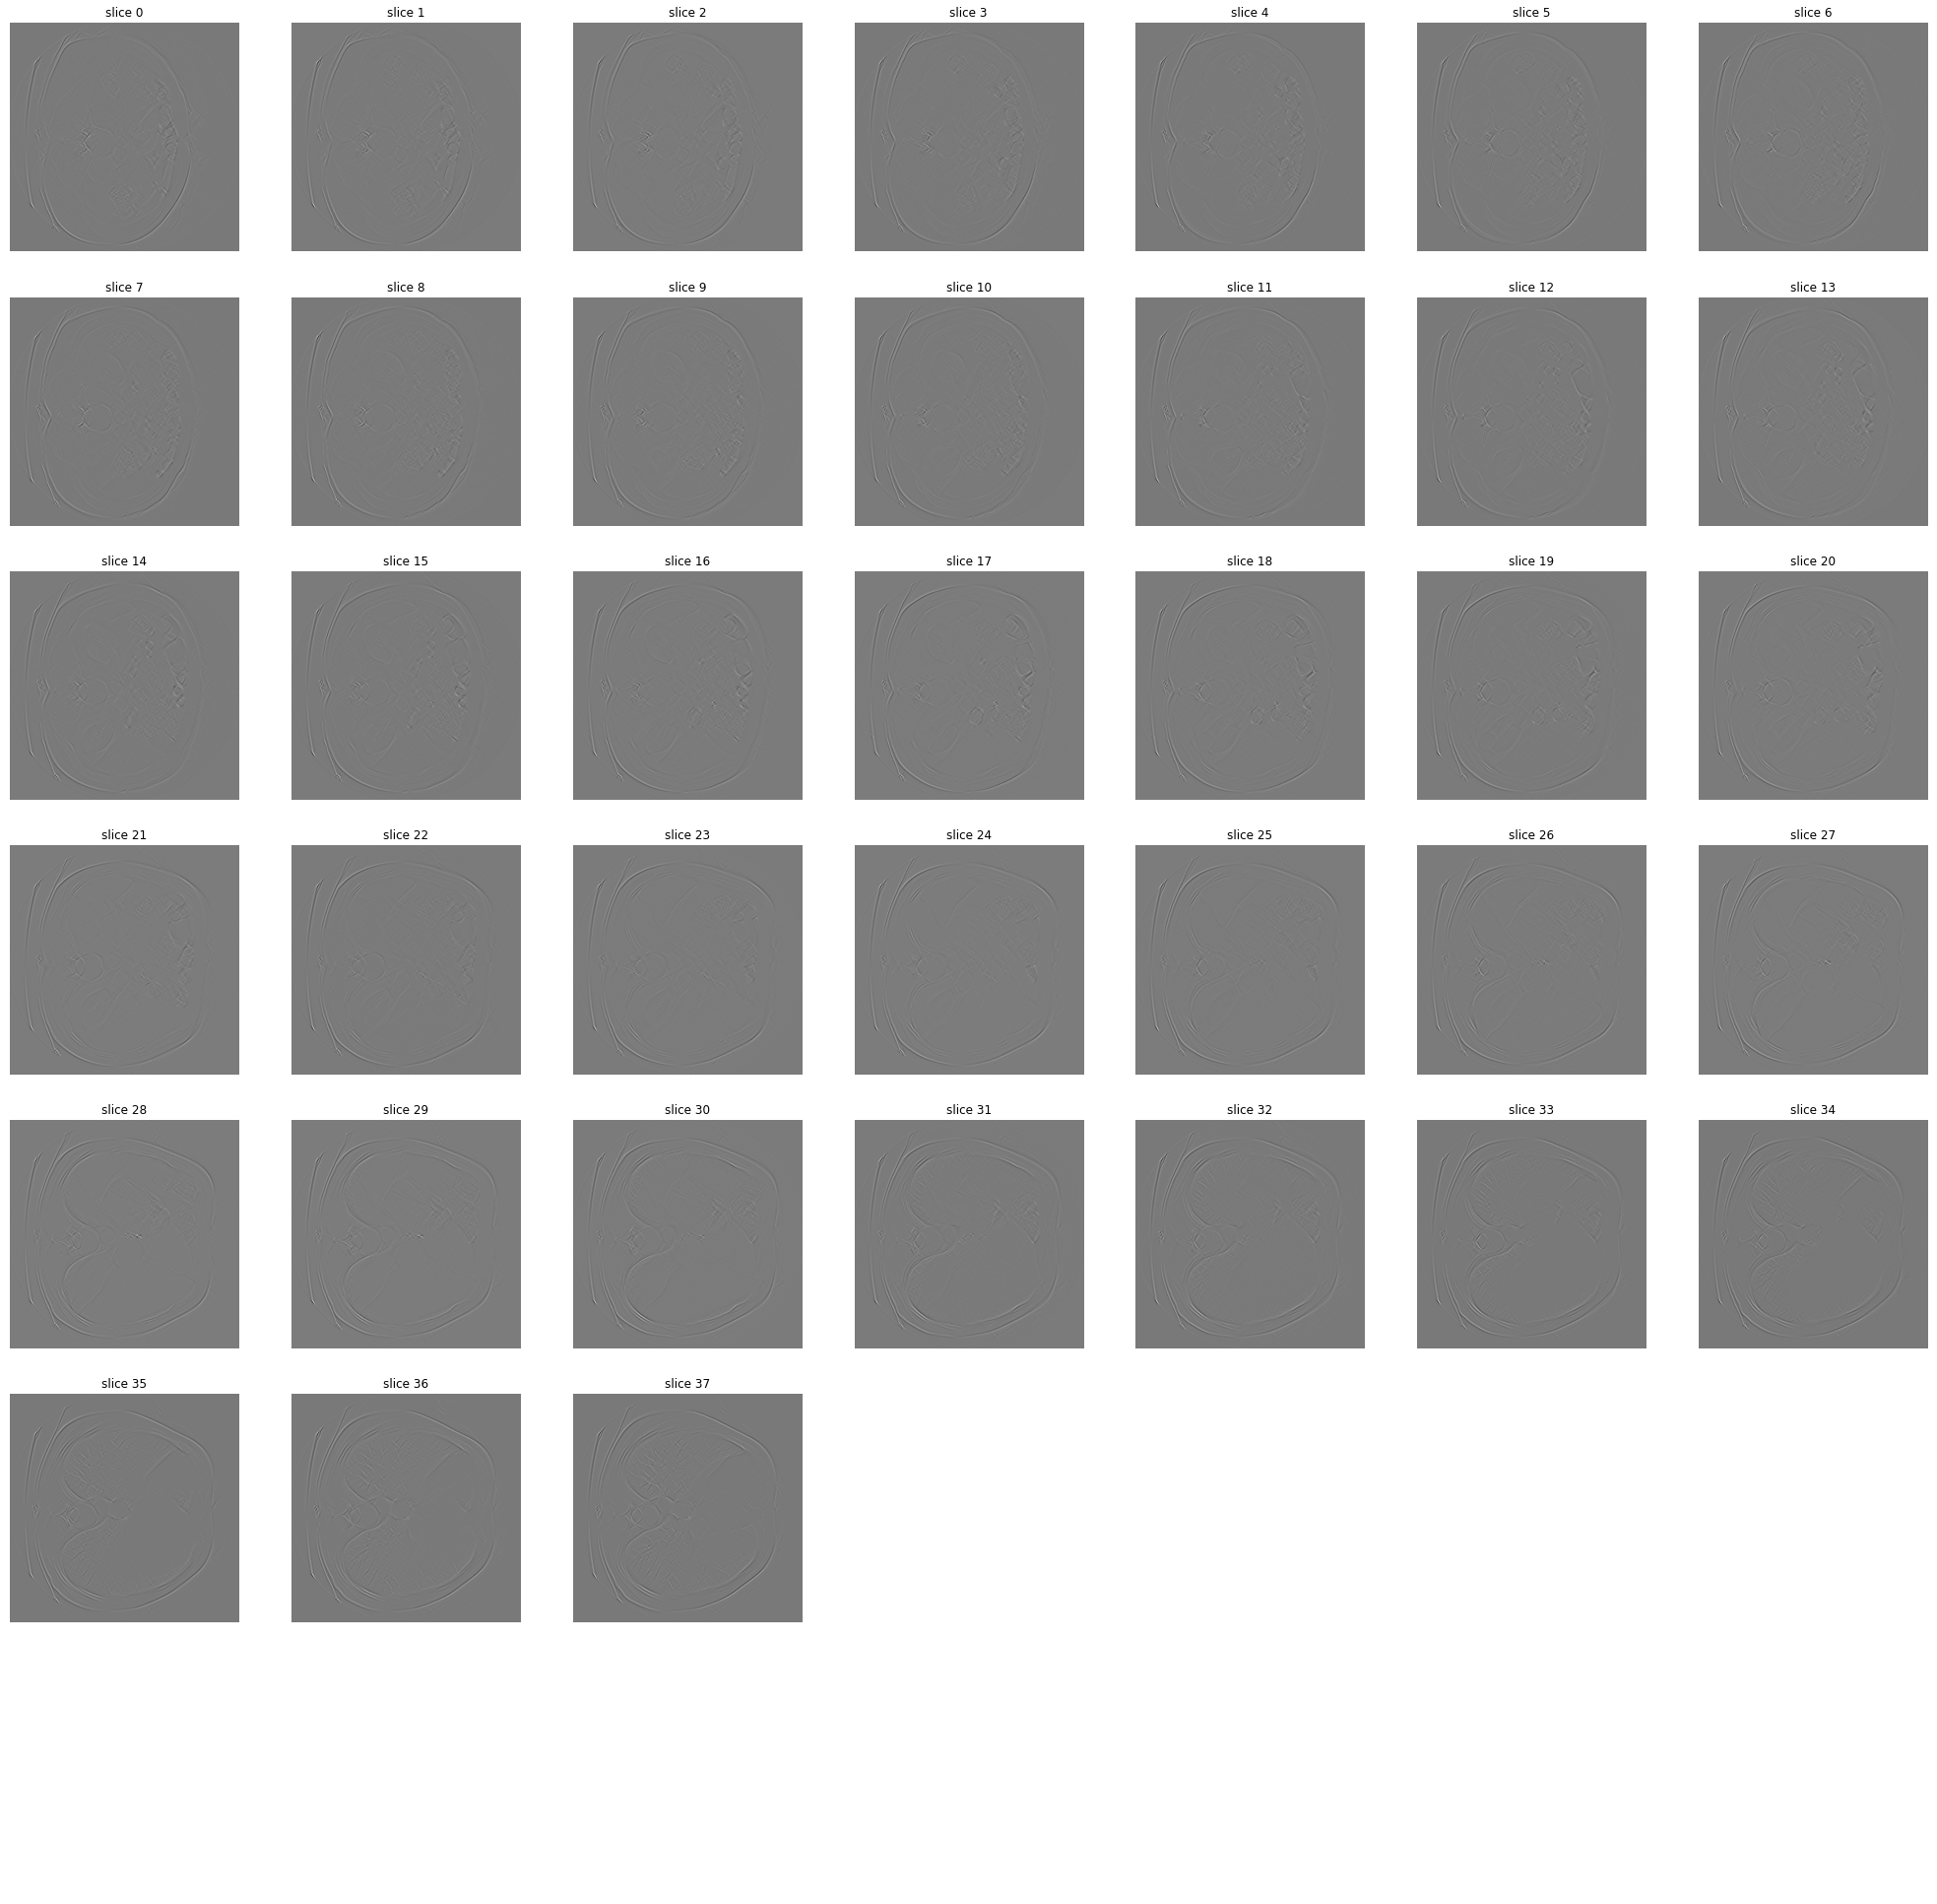

In [33]:
display_volume_slices(convolved_np, 7, 7)

In [34]:
print(f"Number of trainable parameters: {np.prod(conv3d.weight.shape)}")

Number of trainable parameters: 64


----
# 2.5D Convolutions

> **Extra credit exercise**: _Depending on how familiar you are with Numpy and PyTorch, this exercise may take up to a few hours to complete. This exercise may help you understand the architecture of convolutions better, but is not essential to understanding the course. If you feel like this would be too time consuming you are welcome to move on or take a peek at the solution._

Now Let's try 2.5D convolutions. That's a bit more difficult since we want to be specific about how exactly we select data for our extra planes, and also for it to be meaningful we would like to combine data in small areas around area of interest which means we would need to process image in patches. This is not something PyTorch offers right out of the box, and you would engage in something like this if you are conscious of performance, so you would want to have control over this anyway. A bit more coding will be required than previous exercises. 

We will try to recreate the approach to building convolutions which has been presented in [this paper from the NIH](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4295635/). Specifically, we will build a layer that runs a convolutional filter over patches that look like this:

<img src="convolutions.img/25d.jpg" width="200">

**TASK**: Using same kernel, compute and time creation of a volume of convolutional feature maps using the 2.5D convolutions approach by looking at 16x16x16 patches and extracting three square segments from the center of the patch, along the cardinal planes, similar to how it was described in the lesson video. Treat the three 16x16 segments as input channels for your convolutional layer still using one output channel). Visualize all axial slices of your convolutional feature map.



In [35]:
patch_size = 16

In [36]:
# Convenience function - will extract patch_size square patches from 3D img across cardinal planes with center in the 
# middle of each patch and put them into (num_patches, 3, patch_size, patch_size) numpy array

# It assumes that img.shape is divisible by patch_size for the sake of simplicity (which is reasonable - you would 
# likely want to normalize your data anyway)

def extract_patches(img, patch_size, z_level):
    
    # create holder array
    num_patches = (img.shape[0]//patch_size) * (img.shape[1]//patch_size)
    out = np.zeros((num_patches, 3, patch_size, patch_size))
    
    for p_x in range(0,img.shape[0]//patch_size):
        for p_y in range(0,img.shape[1]//patch_size):
            
            # Figure out where the patch should start in our main plane
            patch_start_x = p_x*patch_size
            patch_end_x = patch_start_x + patch_size
            x_center = patch_start_x + patch_size//2

            patch_start_y = p_y*patch_size
            patch_end_y = patch_start_y + patch_size
            y_center = patch_start_y + patch_size//2

            # Figure out where patch starts in ortho planes. 
            # Note that we extract patches in orthogonal direction, therefore indices might go over
            # or go negative
            patch_start_z = max(0, z_level-patch_size//2)
            patch_end_z = patch_start_z + patch_size

            if (patch_end_z >= img.shape[2]):
                patch_end_z -= patch_end_z - img.shape[2]
                patch_start_z = patch_end_z - patch_size

            # Get axial, sagittal and coronal slices, assuming particular arrangement of respective planes in the 
            # input image
            patch_a = img[patch_start_x:patch_end_x, patch_start_y:patch_end_y, z_level]
            patch_s = img[x_center, patch_start_y:patch_end_y, patch_start_z:patch_end_z]
            patch_c = img[patch_start_x:patch_end_x, y_center, patch_start_z:patch_end_z]

            patch_id = p_x*img.shape[0]//patch_size + p_y
            out[patch_id] = np.array([patch_a, patch_s, patch_c])
        
    return out

In [37]:
# Another convenience function to rebuild image from patches, assuming square patches contribute to square image
def build_slice_from_patches(patches):
    img_size = int(math.sqrt(patches.shape[0]))*patches.shape[1]

    out = np.zeros((img_size, img_size))
    
    for i in range(patches.shape[0]):
        x = i // (out.shape[0] // patches.shape[2]) 
        y = i % (out.shape[0] // patches.shape[2]) 

        x_start = x*patches.shape[2]
        x_end = x_start + patches.shape[2]

        y_start = y*patches.shape[2]
        y_end = y_start + patches.shape[2]

        out[x_start:x_end, y_start:y_end] = patches[i]
        
    return out

In [38]:
# Test the two - extract some patches, and put it back together and visualize

patches = extract_patches(img, patch_size, 40)
patches.shape

(1024, 3, 16, 16)

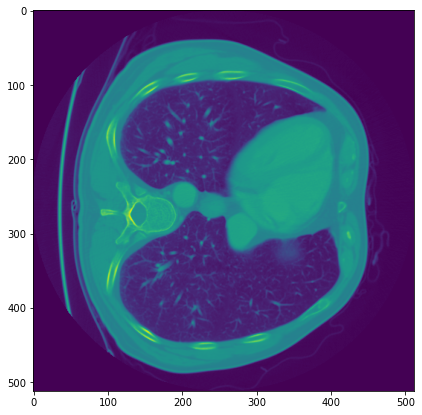

In [39]:
# Rebuild and visualize axials
plt.imshow(build_slice_from_patches(np.squeeze(patches[:,0])))

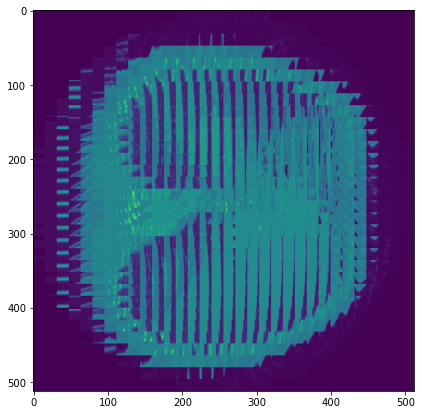

In [40]:
# Looking good, now other planes?
plt.imshow(build_slice_from_patches(np.squeeze(patches[:,1])))


Looking trippy! Anatomy seems distorted but that's something to be expected - remember that our volume has pixels that are non-square? Probably in real world if you wanted to use this in a CNN you would want to rescale everything to square voxels, with some sort of interpolation

In [41]:
# Let's set up the convolutional operator

conv25d = nn.Conv2d(
    3, # Input size == 1 (we are dealing with 3 input channels - one per each orthogonal plane in a patch)
    1, # Output size - we want to get 1 channel as an output
    kernel_size = (4, 4), # size of our filter kernel
    bias = False) # We do not need a bias for this operation
conv25d

Conv2d(3, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)

In [42]:
# Confirm the shape of weights

conv25d.weight.shape

torch.Size([1, 3, 4, 4])

In [43]:
# Set up conv kernel (we will recycle the one from the prev lesson). 
# Remember that we are using 3 conv kernels - one per channel
conv_kernel25d = np.array([conv_kernel, conv_kernel, conv_kernel])

# Initialize layer parameters with the kernel
# Torch expects parameter vector of size (output_channels, input_channels, kernel x dimension, kernel y dimension)
params = torch.from_numpy(conv_kernel25d).type(torch.FloatTensor).unsqueeze(0)
conv25d.weight = torch.nn.Parameter(params)

In [44]:
%%time
# Now, run our convolution operation on all the layers:

conv_slices = []
for z in range(img.shape[2]):
    slice_tensor = torch.from_numpy((extract_patches(img, patch_size, z).astype(np.single)/0xff))
    convolved = conv25d(slice_tensor)
    conv_slices.append(np.squeeze(convolved.detach().numpy()))

CPU times: user 1.13 s, sys: 101 ms, total: 1.23 s
Wall time: 938 ms


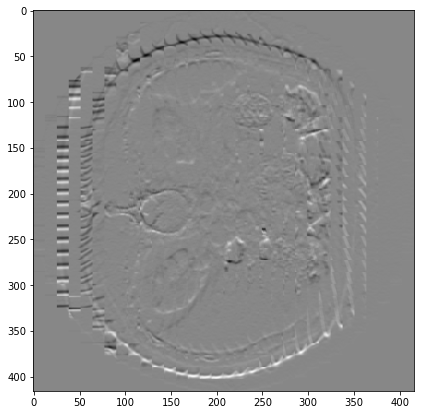

In [45]:
# Visualize a slice
plt.imshow(build_slice_from_patches(conv_slices[20]), cmap="gray")

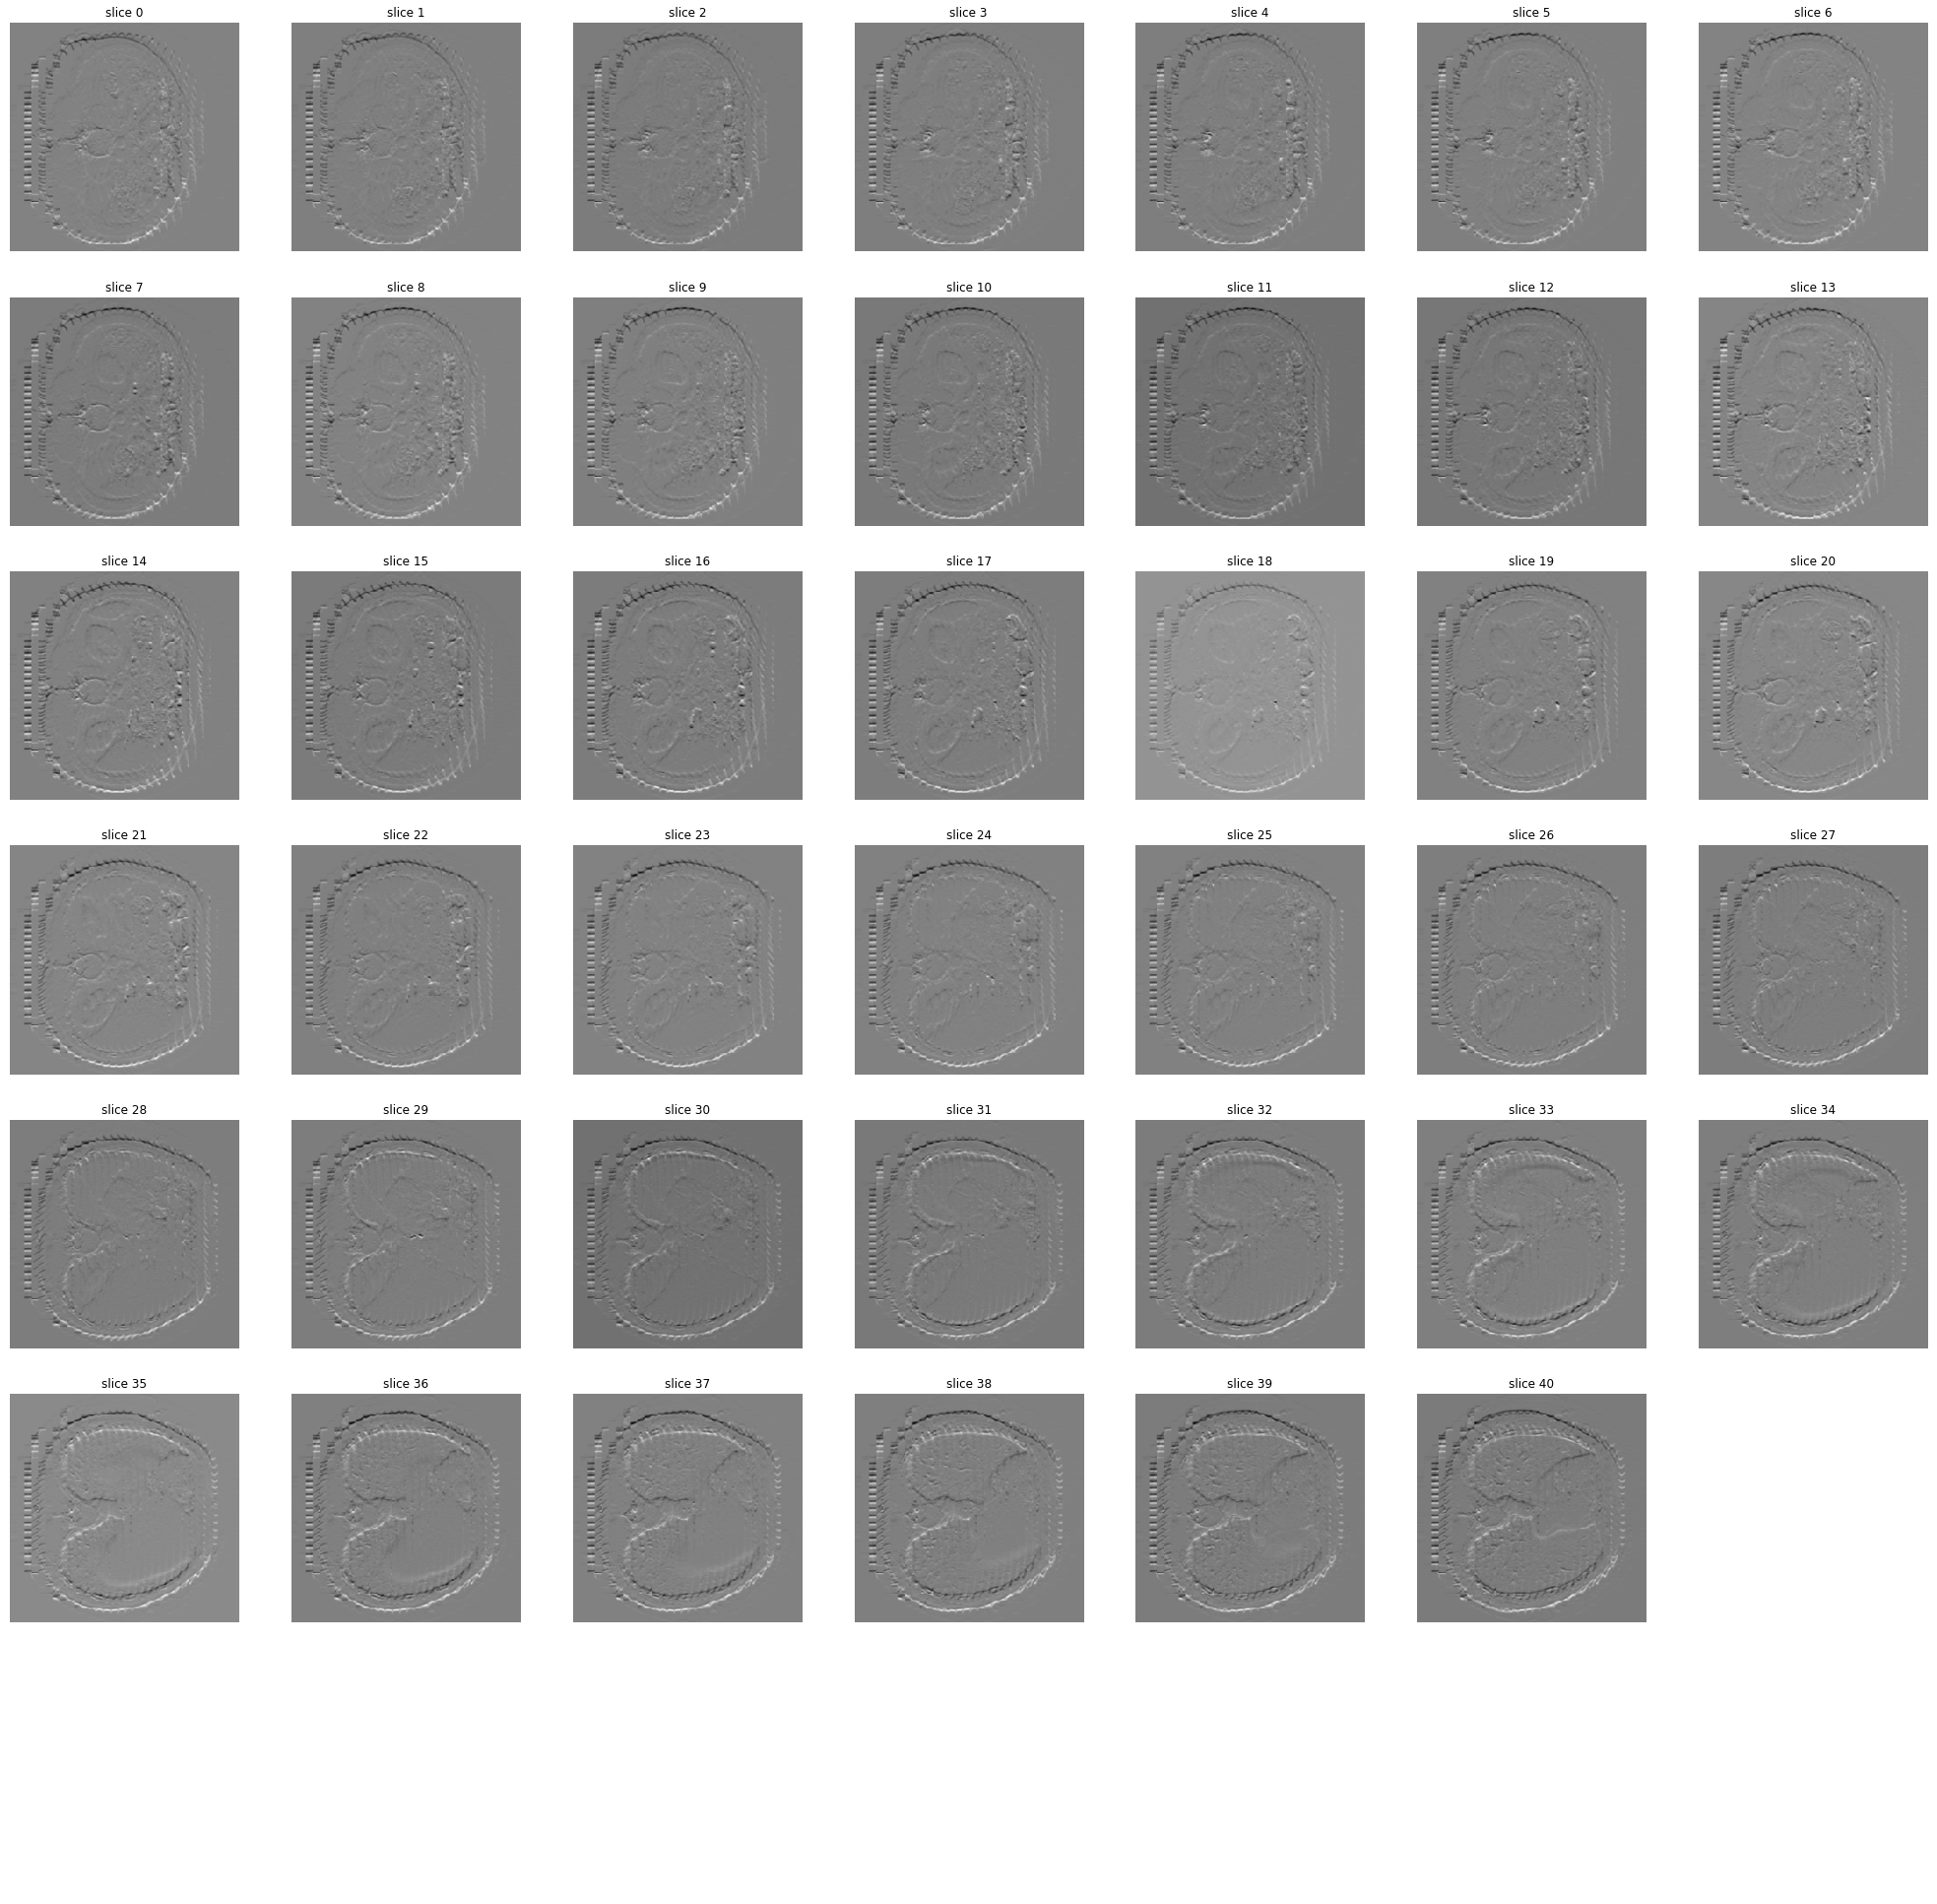

In [46]:
# Visualize a bunch of slices

display_volume_slices([build_slice_from_patches(p) for p in conv_slices], 7, 7)

In [47]:
print(f"Number of trainable parameters: {np.prod(conv25d.weight.shape)}")

Number of trainable parameters: 48
